# Tutorial10_Submission

This notebook contains the submission for Tutorial 10

# Problem Description

A an object of mass, $m$ (in $kg$), sits on a surface. Two horizontal forces are applied, expressed in terms of $f_1$ and $f_2$ (in $N$), with respective angles $f_{1ang}$ and $f_{2ang}$ degrees, defined positive with respect to the x-axis in the anticlockwise direction. 

We can to predict if this will slip or not.

# Libraries

In [1]:
# system libraries

import sys
sys.path.insert(0,'..')

# data related

import pandas as pd
from pandas_profiling import ProfileReport

# mathematical

import numpy as np

# modelling

from sklearn.svm import SVC
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# proprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# plotting

import matplotlib.pyplot as plt 
from Extra_Work.PythonFiles.plotting import plot_classes
from Extra_Work.PythonFiles.plotting import gridspacer, reshape_by_component
from matplotlib.colors import ListedColormap

# evaluation
from sklearn.metrics import f1_score

# Data

In [2]:
path = '../Data/'

df_1 = pd.read_csv(path + 'slip_data.csv')
df_2 = pd.read_csv(path + 'slip_data_full.csv')

In [3]:
# see dataset 1 
df_1.head()

,f1,f1ang,f2,f2ang,m,slips
0,18.0,20.0,21.952540,213.436897,3.0,0.0
1,18.0,20.0,28.607575,3.622930,3.0,1.0
2,18.0,20.0,24.110535,171.297431,3.0,0.0
3,18.0,20.0,21.795327,255.157341,3.0,1.0
4,18.0,20.0,16.946192,15.831156,3.0,1.0


In [4]:
# see dataset 2
df_2.head()

,f1,f1ang,f2,f2ang,m,slips
0,21.952540,269.376473,15.686918,272.925150,3.0,1.0
1,28.607575,64.872975,1.646263,181.194664,3.0,1.0
2,24.110535,140.048332,36.932023,63.725999,3.0,1.0
3,21.795327,13.536065,16.249399,299.713142,3.0,1.0
4,16.946192,4.243586,37.771287,186.056921,3.0,1.0


### Exploration of data

In [5]:
# create profile report of the data
""" Commented as profile report has already been created """
#df1_profile = ProfileReport(df_1, title="slip_data profile", explorative = True)
#df1_profile.to_file("../Reports/slip_data.html")

#df2_profile = ProfileReport(df_2, title="slip_data_full profile", explorative = True)
#df2_profile.to_file("../Reports/slip_data_full.html")


' Commented as profile report has already been created '

### Analysis of profile report

- Both datasets have a class imbalance problem, where 'slip' is more likely to occur than no slip (this makes sense because of the combination of the angles and forces chosen).

- Both always have mass constant as $m=3\, kg$

- The difference between dataset 1 and 2 is that the former fixes the values of $f_1$ and $f_{1ang}$

This is an interesting problem.

# Task (A) - (C)

- Choose either an SVC or NN to classify the data
- What are the advantages of using ML for this task, compared to a traditional engineering approach
- What are the disadvantages of using ML?
- Compare your results with a physics (analytical) method




In [6]:
X = df_1.copy()
def slips(X, mu = 0.5, m = 3):
    """ 
    determines whether the object will slip or not for different input conditions
    
    Dependencies:
    -------------
    
    Parameters:
    -----------
    
    """
    
    # convert to radians
    X[['f1ang', 'f2ang']] = X[['f1ang', 'f2ang']] * np.pi / 180

    vertical_forces = np.sin(X['f1ang']) * X['f1'] + np.sin(X['f2ang']) * X['f2']
    horizontal_forces = np.cos(X['f1ang']) * X['f1'] + np.cos(X['f2ang']) * X['f2']
    X['slips_calculated'] = \
    (np.sqrt(vertical_forces ** 2 + horizontal_forces ** 2) > mu * m * 9.81).astype(int)
    
    return X

## Use SVM on the data

### Prepare data

In [7]:
scaler = StandardScaler()
X = df_1[['f2','f2ang']]
X = scaler.fit_transform(X)
y = df_1['slips']

In [8]:
svc = SVC(C=1000, gamma='scale', kernel='rbf')
svc.fit(X, y)

yhat = svc.predict(X)
print((yhat == y).sum()/len(yhat))


0.999


[[0.00000000e+00 0.00000000e+00]
 [2.01005025e-01 0.00000000e+00]
 [4.02010050e-01 0.00000000e+00]
 ...
 [3.95979899e+01 3.60000000e+02]
 [3.97989950e+01 3.60000000e+02]
 [4.00000000e+01 3.60000000e+02]]


Text(4, 0.66, '$slips = 1$: body will slip')

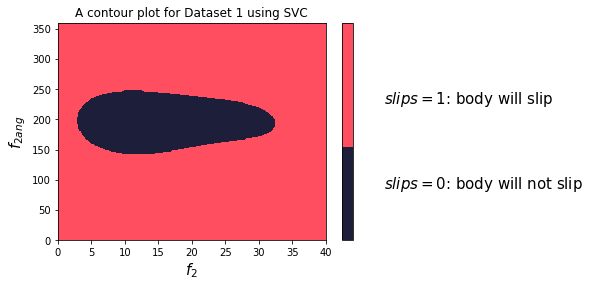

In [9]:
lines, Xgrid, axes = gridspacer([0,40, 200],[0, 360, 200])
print(Xgrid)
Xgrid = scaler.fit_transform(Xgrid)
yhat = svc.predict(Xgrid)
yhat_svm = yhat.copy()

yhat = reshape_by_component(yhat, *axes)


cMap = ListedColormap(['#1d1e3a','#ff4e60'])

plt.contourf(*axes, yhat, cmap = cMap)
plt.title('A contour plot for Dataset 1 using SVC')
plt.ylabel('$f_{2ang}$', fontsize = 15)
plt.xlabel('$f_2$',fontsize = 15)



#legend
cbar = plt.colorbar()

cbar.ax.get_yaxis().set_ticks([])
cbar.ax.text(4, 0.25,'$slips = 0$: body will not slip', fontsize = 15) 
cbar.ax.text(4, 0.66,'$slips = 1$: body will slip', fontsize = 15)



Text(4, 0.66, '$slips = 1$: body will slip')

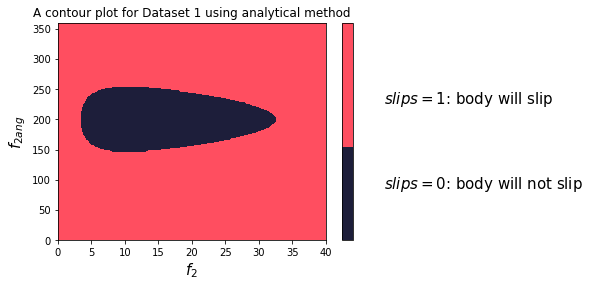

In [10]:
angle = 20
mag = 18

lines, Xgrid, axes = gridspacer([0,40, 200],[0, 360, 200])
vertical_forces = np.sin(angle * np.pi / 180) * mag + np.sin(Xgrid[:,1] * np.pi /180) * Xgrid[:,0]
horizontal_forces = np.cos(angle * np.pi / 180) * mag + np.cos(Xgrid[:,1] * np.pi /180) * Xgrid[:,0]
yhat = \
(np.sqrt(vertical_forces ** 2 + horizontal_forces ** 2) > 0.5 * 3 * 9.81).astype(int)

yhat_true = yhat.copy()


yhat = reshape_by_component(yhat, *axes)


cMap = ListedColormap(['#1d1e3a','#ff4e60'])

plt.contourf(*axes, yhat, cmap = cMap)
plt.title('A contour plot for Dataset 1 using analytical method')
plt.ylabel('$f_{2ang}$', fontsize = 15)
plt.xlabel('$f_2$',fontsize = 15)



#legend
cbar = plt.colorbar()

cbar.ax.get_yaxis().set_ticks([])
cbar.ax.text(4, 0.25,'$slips = 0$: body will not slip', fontsize = 15) 
cbar.ax.text(4, 0.66,'$slips = 1$: body will slip', fontsize = 15)

## Use NN on the data

### Prepare data

In [11]:
scaler = StandardScaler()
X = df_1[['f2','f2ang']]
X = scaler.fit_transform(X)
y = df_1['slips']

y_binary = to_categorical(y)

In [12]:
def uncompiled_model():
    inputs = Input(shape=(2,), name='Data')

    x = Dense(4, activation = 'tanh')(inputs)
    
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs = inputs, outputs = outputs)
    
    return model

def compile_model():
    model = uncompiled_model()
    model.compile(
        optimizer='adam', 
        loss="binary_crossentropy",
        metrics=["accuracy",
                 ],
    )
    return model

In [13]:
model = compile_model()
history = model.fit(X, y_binary, epochs = 1200, verbose = 0)


Text(4, 0.66, '$slips = 1$: body will slip')

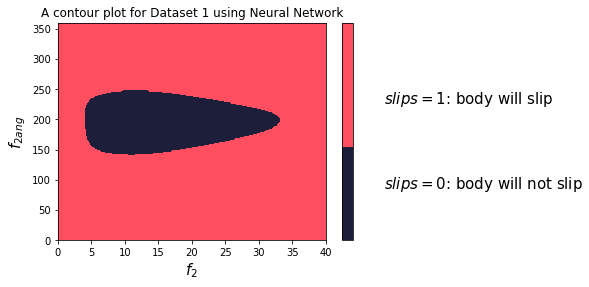

In [14]:
lines, Xgrid, axes = gridspacer([0,40, 200],[0, 360, 200])
Xgrid = scaler.fit_transform(Xgrid)
yhat = model.predict(Xgrid)
yhat = yhat[:,1]
yhat[yhat > 0.5] = 1
yhat[yhat != 1] = 0
yhat_nn = yhat.copy()

yhat = reshape_by_component(yhat, *axes)


cMap = ListedColormap(['#1d1e3a','#ff4e60'])

plt.contourf(*axes, yhat, cmap = cMap)
plt.title('A contour plot for Dataset 1 using Neural Network')
plt.ylabel('$f_{2ang}$', fontsize = 15)
plt.xlabel('$f_2$',fontsize = 15)



#legend
cbar = plt.colorbar()

cbar.ax.get_yaxis().set_ticks([])
cbar.ax.text(4, 0.25,'$slips = 0$: body will not slip', fontsize = 15) 
cbar.ax.text(4, 0.66,'$slips = 1$: body will slip', fontsize = 15)

### See which model is better

In [15]:
# accuracy of NN model

print((yhat_nn == yhat_true).sum() / len(yhat_true))
print(f1_score(yhat_true, yhat_nn))

# accuracy of SVC model

print((yhat_svm == yhat_true).sum() / len(yhat_true))
print(f1_score(yhat_true, yhat_svm))



0.9802
0.9881688625974725
0.982325
0.9894090330312335


# Task (D)

In [16]:
X = df_2[['f1','f1ang','f2','f2ang']]
mean = np.asarray(X[['f1','f1ang']].mean())
std = np.asarray(X[['f1','f1ang']].std())
y = df_2['slips']
X = scaler.fit_transform(X)

In [17]:
svc = SVC(C=1000, gamma='scale', kernel='rbf')
svc.fit(X, y)

SVC(C=1000)

[[-0.85101567 -1.41400445 -1.7234121  -1.7234121 ]
 [-0.85101567 -1.41400445 -1.70609137 -1.7234121 ]
 [-0.85101567 -1.41400445 -1.68877065 -1.7234121 ]
 ...
 [-0.85101567 -1.41400445  1.68877065  1.7234121 ]
 [-0.85101567 -1.41400445  1.70609137  1.7234121 ]
 [-0.85101567 -1.41400445  1.7234121   1.7234121 ]]
[0. 0. 0. ... 1. 1. 1.]


Text(4, 0.66, '$slips = 1$: body will slip')

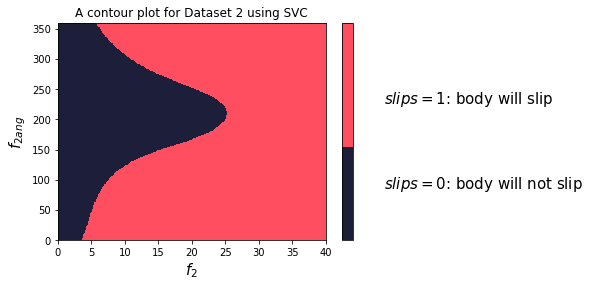

In [29]:
lines, Xgrid, axes = gridspacer([0,40, 200],[0, 360, 200])
f1 = np.ones([Xgrid.shape[0],1]) * 10
f1ang = np.ones([Xgrid.shape[0],1]) * 30
Xgrid = scaler.fit_transform(Xgrid)
X_temp = np.concatenate([f1, f1ang], axis = 1)

X_temp = (X_temp - mean.reshape(-1,2)) / std.reshape(-1,2)
Xgrid = np.concatenate([X_temp, Xgrid], axis = 1)

print(Xgrid)
yhat = svc.predict(Xgrid)
print(yhat)
yhat_SVC = yhat.copy()
yhat = reshape_by_component(yhat, *axes)


cMap = ListedColormap(['#1d1e3a','#ff4e60'])

plt.contourf(*axes, yhat, cmap = cMap)
plt.title('A contour plot for Dataset 2 using SVC')
plt.ylabel('$f_{2ang}$', fontsize = 15)
plt.xlabel('$f_2$',fontsize = 15)




cbar = plt.colorbar()

cbar.ax.get_yaxis().set_ticks([])
cbar.ax.text(4, 0.25,'$slips = 0$: body will not slip', fontsize = 15) 
cbar.ax.text(4, 0.66,'$slips = 1$: body will slip', fontsize = 15)

In [43]:
X = pd.DataFrame(data = {'f1':np.linspace(10,10,40000),
                         'f1ang':np.linspace(30,30,40000)})

lines, Xgrid, axes = gridspacer([0,40, 200],[0, 360, 200])
X[['f2','f2ang']] = Xgrid
Xgrid = slips(X)

Text(4, 0.66, '$slips = 1$: body will slip')

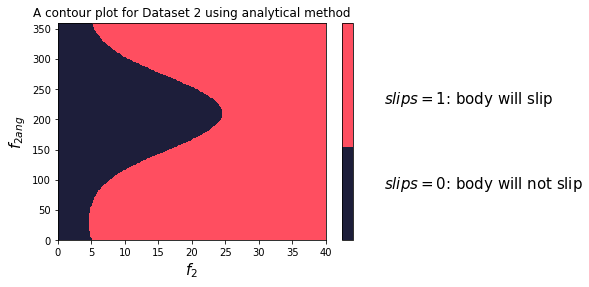

In [46]:
y = Xgrid['slips_calculated'].copy()
y_true = y.copy()
y = reshape_by_component(np.asarray(y), *axes)
cMap = ListedColormap(['#1d1e3a','#ff4e60'])

# this is wrong!
plt.contourf(*axes, y, cmap = cMap)
plt.title('A contour plot for Dataset 2 using analytical method')
plt.ylabel('$f_{2ang}$', fontsize = 15)
plt.xlabel('$f_2$',fontsize = 15)




cbar = plt.colorbar()

cbar.ax.get_yaxis().set_ticks([])
cbar.ax.text(4, 0.25,'$slips = 0$: body will not slip', fontsize = 15) 
cbar.ax.text(4, 0.66,'$slips = 1$: body will slip', fontsize = 15)

In [47]:
print((yhat_SVC == y_true).sum() / len(y_true))


0.98555
